# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
# The CiFAR-10 dataset has 10 classes and 60k images
# Here only 3 classes are used and only 15k images
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    # eg and labels corresponding to those indices
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    # shuffle the indices so they're not in a sequence
    indices = np.random.choice(range(count), count, replace=False)
    #.....................List 0 to count-1, no. of choices, random but unique
    
    x = x[indices]
    y = y[indices]
    
    # convert the labels to 1-hot encoded vec
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [4]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

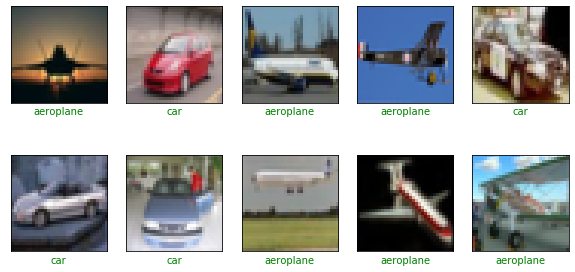

In [11]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_eg(x,y,p):
    indices = np.random.choice(range(x.shape[0]),10, replace=False)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        
        # Right predictions will be in green and wrong will be in red
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

# Now test the function
show_random_eg(x_train, y_train, y_train)     
# We don't have predictions yet, hence we're sending the ground truth again

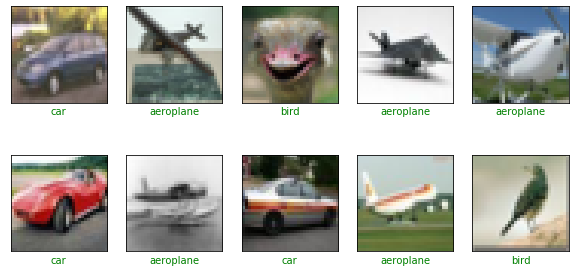

In [12]:
# This is just for testing the function
show_random_eg(x_test, y_test, y_test)     
# We don't have predictions yet, hence same case as above

# Task 4: Create Model

In [14]:
# import layer properties to create model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, no_filter):
        model.add(Conv2D(no_filter,3,activation='relu',padding='same'))
        # kernel size = 3
        model.add(BatchNormalization())
        model.add(Conv2D(no_filter,3,activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        # Reduces rows and cols to 0.5 of original val
        return model
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(32,32,3)))
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model.add(Flatten())
    #Dense layer with 3 nodes and softmax activation
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)       

# Task 5: Train the Model

In [17]:
epochs = 25
batch_size=128
# Early stopping so as to not waste time and stop if model is deteriorating
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                           patience=3),
           tf.keras.callbacks.ModelCheckpoint('models/model_acc_{val_accuracy:.2f}.h5',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             monitor='val_accuracy')]
history = model.fit(x_train/255., y_train, 
                    validation_data=(x_test/255.,y_test),
                   epochs=epochs, batch_size=batch_size,
                   callbacks=callbacks)

Train on 15000 samples, validate on 3000 samples
Epoch 1/25
15000/15000 [==============================] - 144s 10ms/sample - loss: 0.8923 - accuracy: 0.6764 - val_loss: 3.0964 - val_accuracy: 0.3333
Epoch 2/25
15000/15000 [==============================] - 139s 9ms/sample - loss: 0.5355 - accuracy: 0.7838 - val_loss: 2.5551 - val_accuracy: 0.5180
Epoch 3/25
15000/15000 [==============================] - 141s 9ms/sample - loss: 0.4810 - accuracy: 0.8117 - val_loss: 1.8003 - val_accuracy: 0.5337
Epoch 4/25
15000/15000 [==============================] - 139s 9ms/sample - loss: 0.4400 - accuracy: 0.8227 - val_loss: 1.3112 - val_accuracy: 0.5887
Epoch 5/25
15000/15000 [==============================] - 137s 9ms/sample - loss: 0.3993 - accuracy: 0.8429 - val_loss: 0.7538 - val_accuracy: 0.7240
Epoch 6/25
15000/15000 [==============================] - 137s 9ms/sample - loss: 0.3614 - accuracy: 0.8586 - val_loss: 0.3715 - val_accuracy: 0.8590
Epoch 7/25
15000/15000 [==========================

# Task 6: Final Predictions

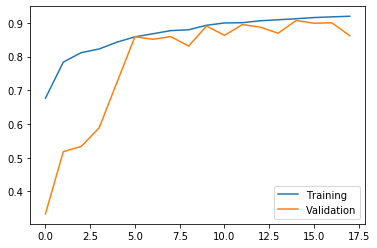

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# len(acc) is actually no. of epochs the model ran
plt.plot(range(len(acc)), acc, label='Training')
plt.plot(range(len(acc)), val_acc, label='Validation')
plt.legend()
plt.show()

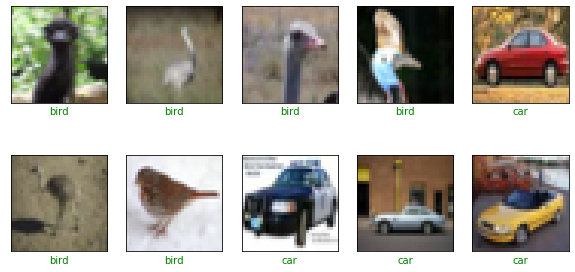

In [19]:
model = tf.keras.models.load_model('models/model_acc_0.91.h5')
preds = model.predict(x_test/255.)
show_random_eg(x_test, y_test, preds)